In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.statistics as stat
%matplotlib inline

## Как распределён фон по мультиадронному генератору

In [7]:
multi_df = uproot.open('../trees/19/multihadrons_withoutrho.root')['t']
df = preprocess.read_tree(multi_df, mc=True, align_cut=None)
align_cut = 0.8

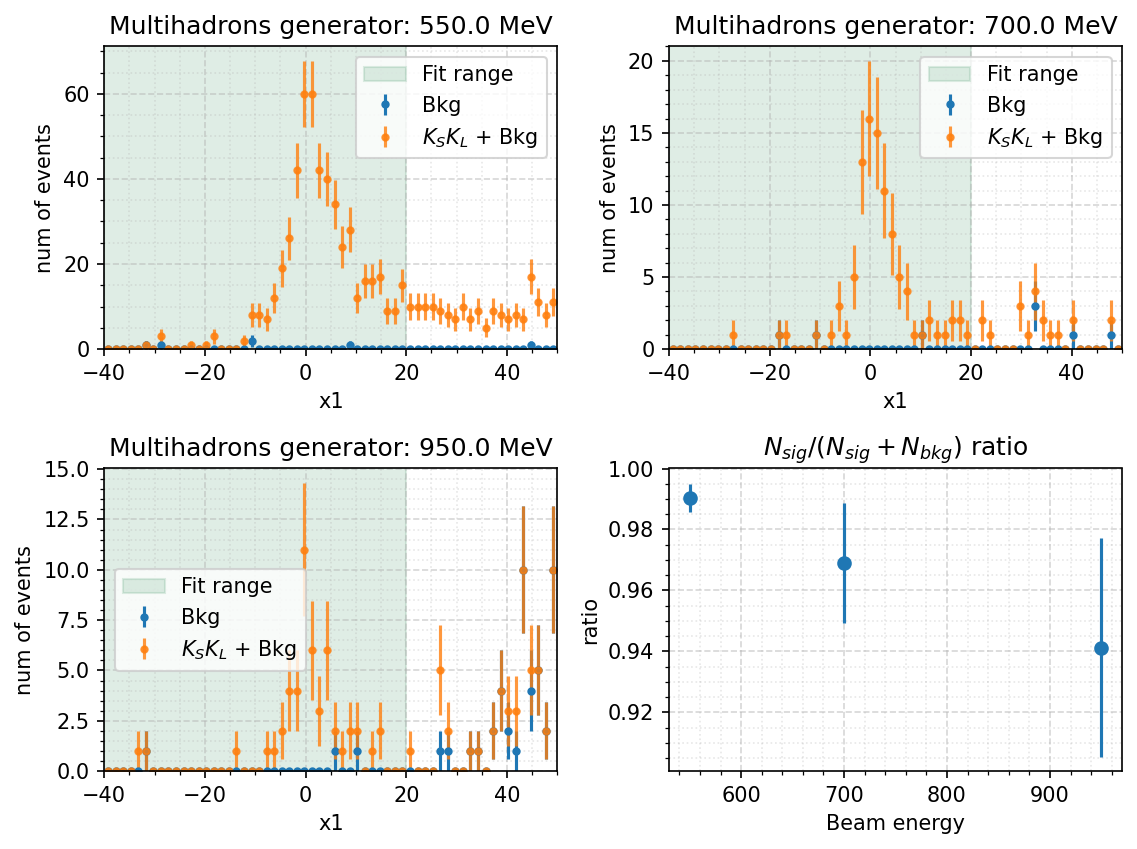

In [156]:
energies = sorted(set(df.index))
plt.figure(dpi=150, figsize=(1.2*6.4, 1.2*4.8))
xmin_fit, xmax_fit = -40, 20
num_sig, num_all = [], []
for i, e in enumerate(energies):
    plt.subplot(int(str(f"22{i+1}")))
    temp = df.loc[e].query('ksalign>@align_cut').copy()
    sig = temp.query('sim_parts=="$K_L$$K_S$"')
    bkg = temp.query('sim_parts!="$K_L$$K_S$"')
    num_sig.append(len(sig.query('x1>@xmin_fit&x1<@xmax_fit')))
    num_all.append(len(temp.query('x1>@xmin_fit&x1<@xmax_fit')))
    bins, hist_range = 60, (-40, 50)
    pys.hep_histo(bkg.x1, bins=bins, range=hist_range, label='Bkg')
    pys.hep_histo(temp.x1, bins=bins, range=hist_range, label='$K_SK_L$ + Bkg', alpha=0.8)
    plt.ylim(0, None)
    plt.xlim(*hist_range)
    plt.fill_betweenx([0, 1e5], xmin_fit, xmax_fit, alpha=0.15, color='seagreen', label='Fit range')
    pys.my_style(f'Multihadrons generator: {temp.index[0]} MeV', 'x1', 'num of events', legend=True)
    del temp, sig, bkg
plt.subplot(224)
num_sig, num_all = np.array(num_sig), np.array(num_all)
plt.errorbar(energies, num_sig/num_all, yerr=stat.efficiency_error(num_sig, num_all), fmt='o');
pys.my_style('$N_{sig}/(N_{sig} + N_{bkg})$ ratio', 'Beam energy', 'ratio', legend=False, ylim=(None, 1))
# plt.savefig('./images/multics/multics_new.png')

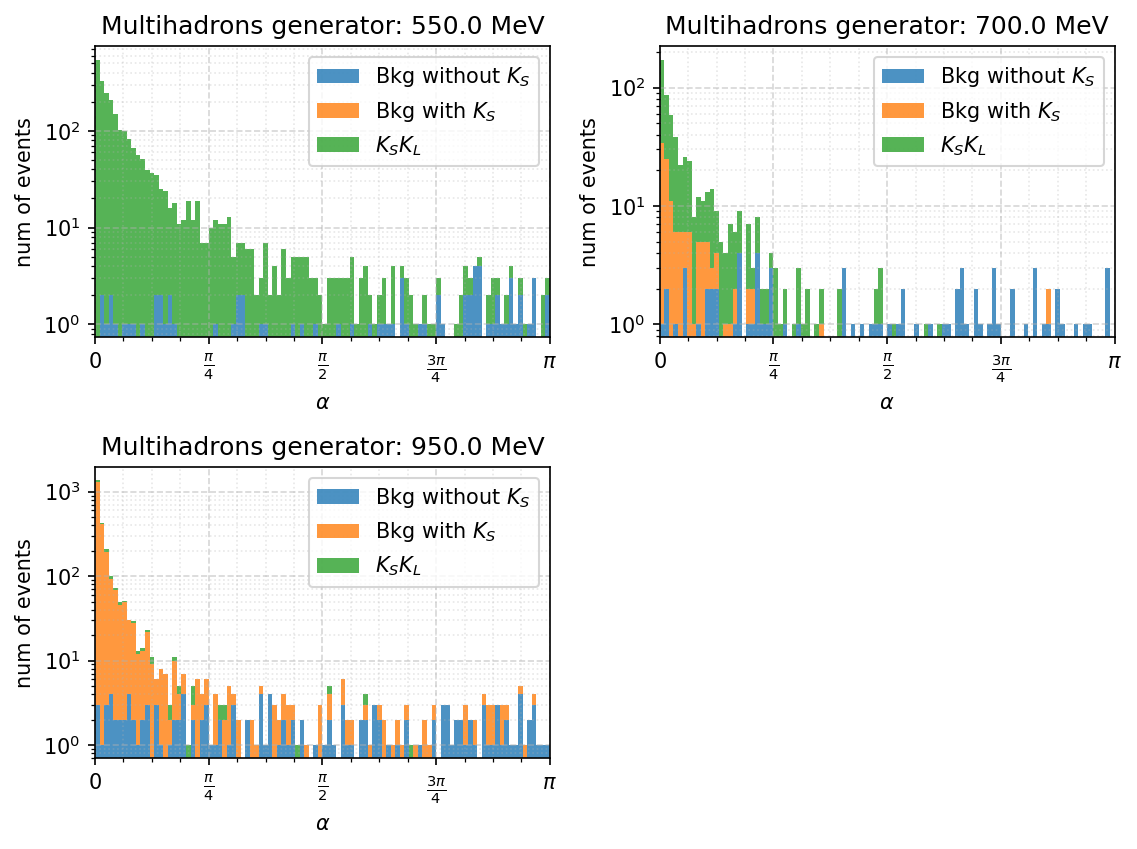

In [10]:
energies = sorted(set(df.index))
plt.figure(dpi=150, figsize=(1.2*6.4, 1.2*4.8))
for i, e in enumerate(energies):
    plt.subplot(int(str(f"22{i+1}")))
    temp = df.loc[e].copy()
    sig = temp.query('sim_parts=="$K_L$$K_S$"')
    temp['is_KS'] = (temp.sim_parts.str.find('K_S') > 0)
    bkgKS = temp.query('(sim_parts!="$K_L$$K_S$")&(is_KS)')
    bkgWithoutKS = temp.query('(sim_parts!="$K_L$$K_S$")&(~is_KS)')
    bins, hist_range = 100, (0, np.pi)
    plt.hist([bkgWithoutKS.ksangle, bkgKS.ksangle, sig.ksangle], 
             bins=100, range=(0,np.pi), label=['Bkg without $K_S$', 'Bkg with $K_S$', '$K_SK_L$'], stacked=True, alpha=0.8);
    plt.xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], ['0', '$\\frac{\pi}{4}$', '$\\frac{\pi}{2}$', '$\\frac{3\pi}{4}$', '$\pi$'])
    plt.yscale('log')
    pys.my_style(f'Multihadrons generator: {temp.index[0]} MeV', '$\\alpha$', 'num of events', legend=True, xlim=hist_range)
    del temp, sig, bkgKS, bkgWithoutKS
del energies
# plt.savefig('./images/multics_alpha.png')

## Как распределены события, не прошедшие `ksalign`

In [16]:
exp_trees = uproot.open('../trees/19/exp.root')['t']
df_exp = preprocess.read_tree(exp_trees, mc=False, align_cut=None)

mc_trees = uproot.open('../trees/19/mc.root')['t']
df_mc = preprocess.read_tree(mc_trees, mc=True, align_cut=None, sim_parts=False)

energies_ = [550., 700., 800., 950.]

assert np.any( df_exp.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 ) #check energies in df
assert np.any( df_mc.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 )
assert np.all( np.isin(energies_, df_exp.index) ) #check energies list
assert np.all( np.isin(energies_, df_mc.index) )

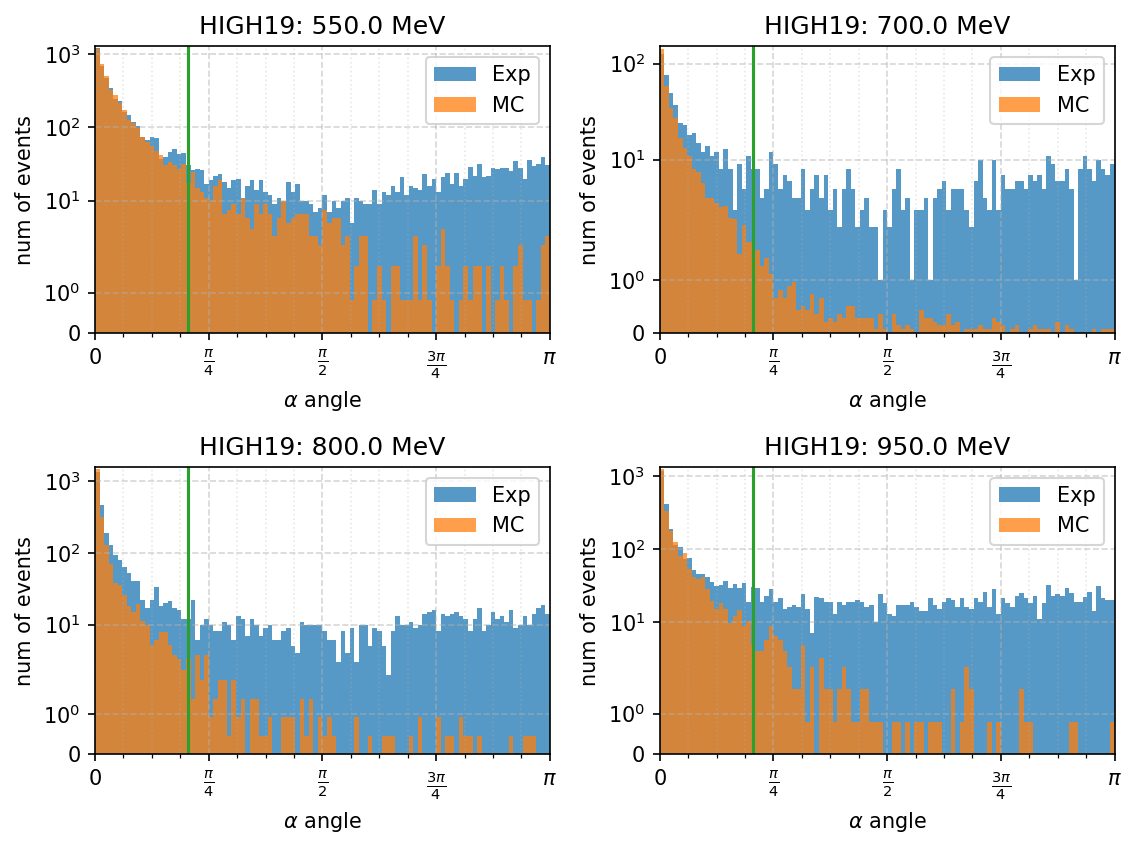

In [17]:
plt.figure(dpi=150, figsize=(1.2*6.4, 1.2*4.8))
bins, hist_range = 100, (0, np.pi)
for i, e in enumerate(energies_):
    plt.subplot(int(str(f"22{i+1}")))
    temp_exp = df_exp.loc[e].copy()
    temp_mc = df_mc.loc[e].copy()
    plt.hist(temp_exp.ksangle, bins=bins, range=hist_range, alpha=0.75, label='Exp')
    hist_data_exp, _ = np.histogram(temp_exp.ksangle, bins=bins, range=hist_range)
    hist_data_mc, _ = np.histogram(temp_mc.ksangle, bins=bins, range=hist_range)
    plt.hist(temp_mc.ksangle, bins=bins, range=hist_range, alpha=0.75, 
             weights=np.ones_like(temp_mc.ksangle)*hist_data_exp[:2].sum()/hist_data_mc[:2].sum(), label='MC')
    plt.xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], ['0', '$\\frac{\pi}{4}$', '$\\frac{\pi}{2}$', '$\\frac{3\pi}{4}$', '$\pi$'])
    plt.ylim(0, None)
    plt.plot(np.arccos([0.8, 0.8]), [0, 1e5])
    plt.yscale('symlog')
    pys.my_style(f'HIGH19: {temp_exp.index[0]} MeV', '$\\alpha$ angle', 'num of events', legend=True, xlim=hist_range)
    del temp_exp, temp_mc
# plt.savefig('./images/exp_alpha.png')

Каоны с меньшей энергией обычно имеют больший разброс по $\alpha$, т.к. распадаются близко к пучку

Хвост у 950 в моделировании растёт из-за сброса на резонанс 800, соответственно, т.к. я использую дальше в распределении по x1 события без сбросов, то в принципе всё ок

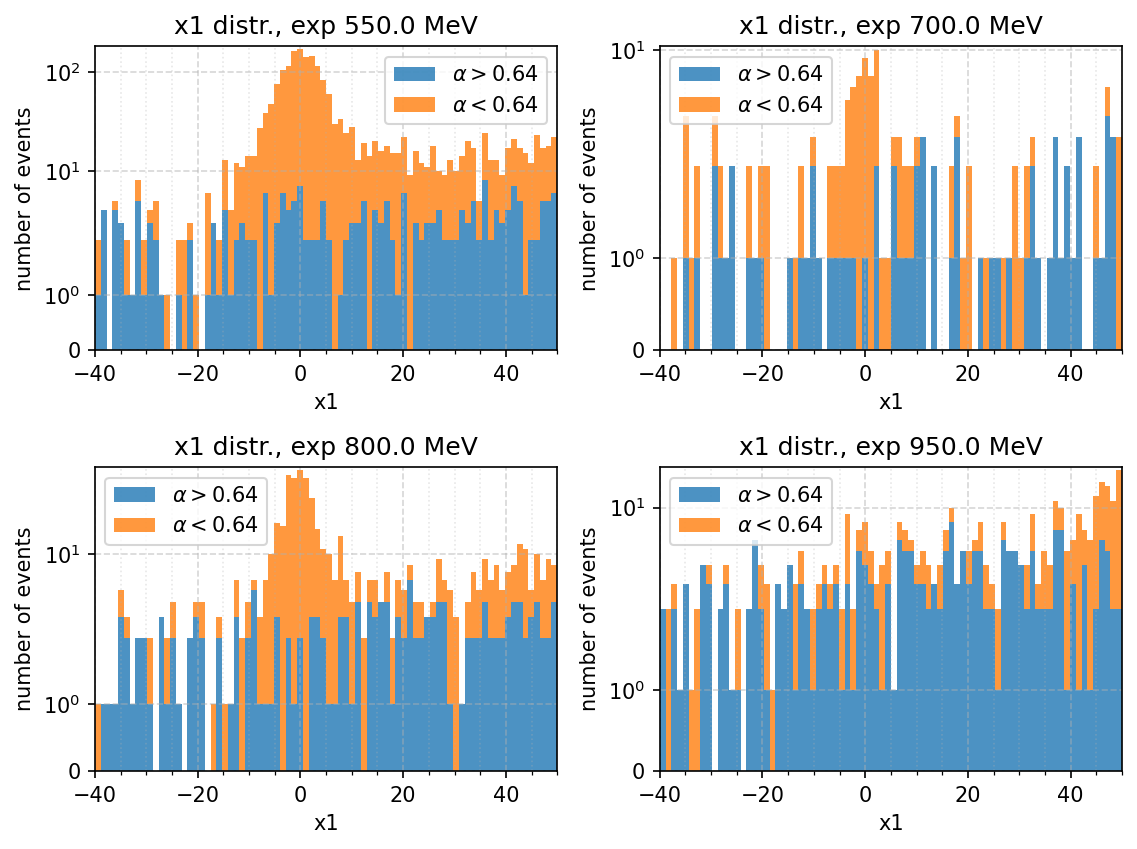

In [18]:
plt.figure(dpi=150, figsize=(1.2*6.4, 1.2*4.8))
bins, hist_range = 80, (-40, 50)
angle_cut = np.arccos(0.8) #np.pi/2
for i, e in enumerate(energies_):
    plt.subplot(int(str(f"22{i+1}")))
    temp_exp = df_exp.loc[e].copy()
    temp_mc = df_mc.loc[e].copy()
    temp_high_angle = temp_exp.query(f'ksangle>@angle_cut').x1
    temp_low_angle = temp_exp.query(f'ksangle<@angle_cut').x1
    
    plt.hist([temp_high_angle, temp_low_angle], stacked=True, range=hist_range, bins=bins, alpha=0.8,
         label=[f'$\\alpha > {angle_cut:.2f}$', f'$\\alpha < {angle_cut:.2f}$'])
    pys.my_style(f'x1 distr., exp {temp_exp.index[0]} MeV', 'x1', 'number of events', xlim=hist_range, legend=True)
    plt.yscale('symlog')
#     pys.my_style(f'Multihadrons generator: {temp_exp.index[0]} MeV', '$\\alpha$ angle', 'num of events', legend=False, xlim=hist_range)
    del temp_exp, temp_mc
# plt.savefig('./images/exp_x1_alpha.png')

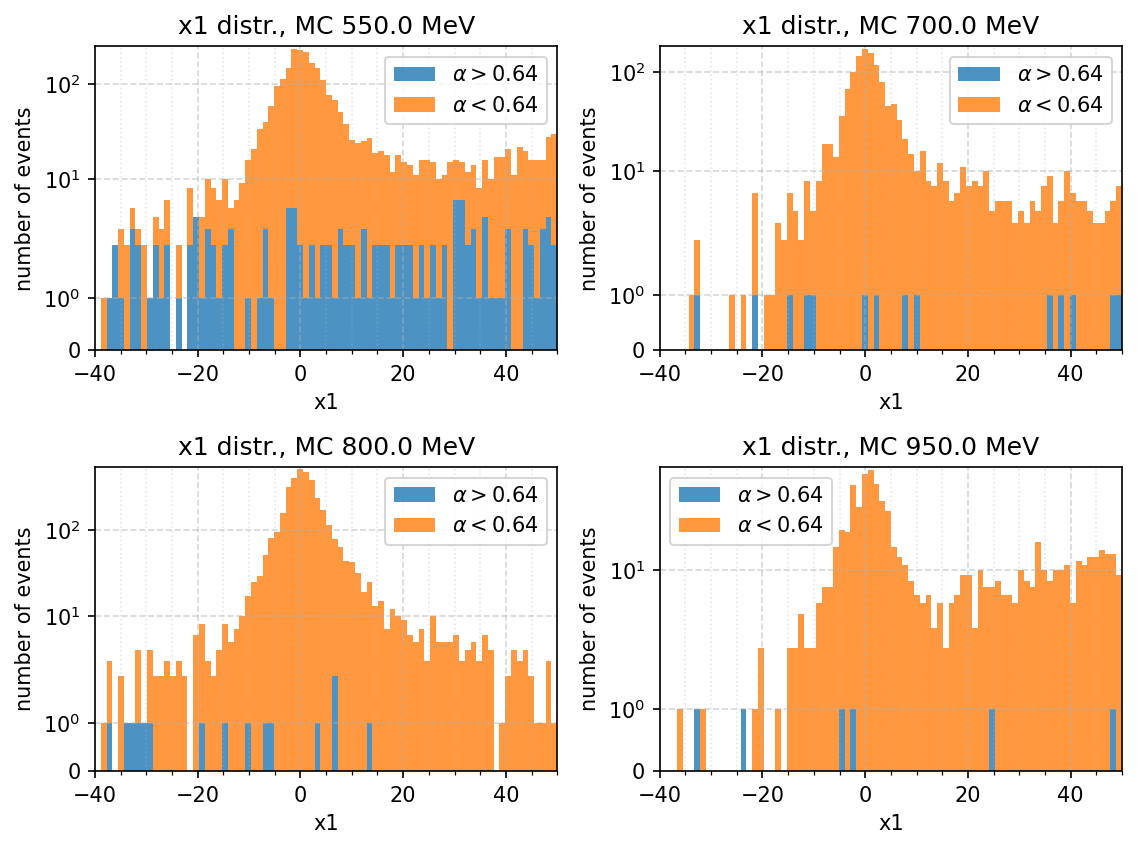

In [269]:
plt.figure(dpi=150, figsize=(1.2*6.4, 1.2*4.8))
bins, hist_range = 80, (-40, 50)
angle_cut = np.arccos(0.8) #np.pi/2
for i, e in enumerate(energies_):
    plt.subplot(int(str(f"22{i+1}")))
    temp_mc = df_mc.loc[e].copy()
    temp_high_angle = temp_mc.query(f'ksangle>@angle_cut').x1
    temp_low_angle = temp_mc.query(f'ksangle<@angle_cut').x1
    
    plt.hist([temp_high_angle, temp_low_angle], stacked=True, range=hist_range, bins=bins, alpha=0.8,
         label=[f'$\\alpha > {angle_cut:.2f}$', f'$\\alpha < {angle_cut:.2f}$'])
    pys.my_style(f'x1 distr., MC {temp_mc.index[0]} MeV', 'x1', 'number of events', xlim=hist_range, legend=True)
    plt.yscale('symlog')
    del temp_mc